## Classifier Model for Succesful Journey Prediction (Downsampling approach)
### Team Name : Data Crew

**Contributions:**
* Axel
* Darren
* Ryan
* Taro
* Dan

This notebook was created in order to implement, train and test the classifier model for the prediction of the successful journey of the customers. We are going to make several testing approaches were the seed 2024 is fixed in order to make all the code and the predictions comparable, the testing approaches are:

* Train test split
* Cross Validation in a Stratifield KFold and KFold

Additonally, as we are going to see further in the notebook, the data has a balancing problem and therefore we are going to use the following techniques in order to solve it:

* SMOTE
* ADASYN
* Up Sampling
* Down Sampling

In the cases were the models were trained using the unbalanced data set we are going to use the f1-score in order to measure the performance of the model, and in the cases were the models were trained using the balanced data set we are going to use the accuracy metric instead.

Finally it is worthwhile mentioning that in the case of the XGBoost model we used a hyperparameter optimization in order to find the best hyperparameters for the model with the Bayesian Optimization approach.

Model proposal: 
* XGBoost
* LGBM
* LR
* GB
* ADABoost
* Neural Network
* Random Forest

* Clustering for improving the accuracy of the models by looking at the errors
* Boosting algotithms are performing better
* Causationg learning
* Discover variable
* Analytics
* Markov Chain

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

# Librarie for Preprocessing (By Us)
from utils import *

# Model Libraries
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Optimización de hiperparámetros
import optuna
from skopt import BayesSearchCV
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

# Reporting a progress bar
from tqdm import tqdm

# Downsample majority class
from sklearn.utils import resample
from sklearn.decomposition import PCA 

# standardize the data
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.callbacks import Callback

from sklearn.metrics import accuracy_score, f1_score

#random.seed(2024)
np.random.seed(2024)

## Data

### Data Retrieval

We retrieve the data from the original source, i.e. the one that is uncleaned and unprocessed. Also we retrive the event definition dataset:

In [2]:
# Reading the dataset
new_dfx = pd.read_csv('../../1. Data/data_with_embeddings.csv')
new_dfx.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,has_prospecting,has_pre_application,...,time_embd_1,time_embd_2,time_embd_3,time_embd_4,event_embd_0,event_embd_1,event_embd_2,event_embd_3,event_embd_4,order_ships
0,2.0,91.0,0,2.0,1,4.0,60.5,1,1,0,...,0.0,0.0,0.291182,0.455151,0.0,0.0,0.0,0.097493,0.320596,1.0
1,1.0,63.0,0,1.0,0,4.0,58.0,1,1,0,...,0.0,0.0,0.158990,0.471587,0.0,0.0,0.0,0.115039,0.345468,0.0
2,1.0,27.0,1,1.0,0,4.0,24.0,1,1,0,...,0.0,0.0,0.135561,0.472970,0.0,0.0,0.0,0.117902,0.353426,0.0
3,1.0,8.0,1,1.0,0,4.0,6.0,1,1,0,...,0.0,0.0,0.048505,0.028250,0.0,0.0,0.0,0.019101,0.048565,0.0
4,1.0,11.0,1,1.0,0,19.0,11.0,1,0,0,...,0.0,0.0,0.059422,0.103953,0.0,0.0,0.0,0.043307,0.145620,0.0


### Separating the columns by type

In this subsection what we are doing is making a list of the columns that are going to be used for the model and then we are going to separate them by type, i.e. numericaL, categorical and boolean.

In [3]:
num_cols = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 
            'time_in_discover', 'time_in_apply', 'time_max', 'time_mean', 'time_std', 
            'total_time_spent', 'event_embd_0', 'event_embd_1', 'event_embd_2', 
            'event_embd_3','event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
            'time_embd_3', 'time_embd_4']

categorical_cols = ['most_repeated_event', 'initial_device']
boolean_cols = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']
target = 'order_ships'

### Balancing the data

In [8]:
# Separate majority and minority classes according to our target variable
df_majority = new_dfx[new_dfx['order_ships'] == 0]
df_minority = new_dfx[new_dfx['order_ships'] == 1]

print('Shape of majority class:', df_majority.shape)
print('Shape of minority class:', df_minority.shape)

Shape of majority class: (1344356, 28)
Shape of minority class: (320626, 28)


#### Downsampling the data

* Random choice method

In [9]:
# Downsample majority class
df_downsampled = df_majority.sample(n=df_minority.shape[0], replace=False, random_state=2024)

# Concatenate the minority class with the downsampled majority class
df_sampled = pd.concat([df_downsampled, df_minority])

#Dropping the indexes from the original dataset
df_majoritie_excluded = df_majority.drop(index=df_downsampled.index)

* Function method

In [10]:
# Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=df_minority.shape[0],     # to match minority class
#                                  random_state=2024) # reproducible results

# # Combine minority class with downsampled majority class
# df_sampled = pd.concat([df_majority_downsampled, df_minority])

# # Display new class counts
# df_sampled['order_ships'].value_counts()

### Separating the data and the target (only for cross validation models and neural network)

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [11]:
# Setting the dataset we are using to train-test the model
df_final = df_sampled
df_final['order_ships'].value_counts()

order_ships
0.0    320626
1.0    320626
Name: count, dtype: int64

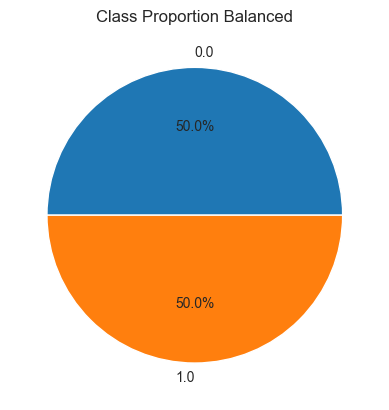

In [12]:
# Separate input features (X) and target variable (y)
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

# Plotting the class proportion
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion Balanced')
plt.show()

* This code is only used if working with up or down sampled data

In [13]:
## Our approach
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(columns=['order_ships']), 
                                                    df_final['order_ships'], 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=2024)

# Resetting the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

numerical = X_train.loc[:,num_cols]

scaler = StandardScaler()
scaler.fit(numerical)
numerical_tran = scaler.transform(numerical)
numerical_test = scaler.transform(X_test[num_cols])

# Concatenate the data to the final dataframe
numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

## Neural Network Model

* We first proceed by splitting the X_train and y_train into train and validation sets.

In [14]:
# Getting the validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              stratify=y_train,
                                                              random_state=2024)

* Then we compute the class weights in order to solve the unbalanced data problem while training our models

In [15]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.reshape(-1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)

Class weights: {0: 1.0000019493177388, 1: 0.9999980506898608}


#### Model Architecture and Approach 1 (Best one so far)

In [16]:
model_1 = Sequential([
    Dense(512, activation='relu', input_shape=(27,)),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(31, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    #Dropout(0.),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
class_weights = {0: 0.6192491008699339, 1: 2.596451865684734} 

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               14336     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [17]:
# Fit the model
history = model_1.fit(X_train_nn, y_train_nn, 
                    epochs=5, 
                    batch_size=128,
                    validation_data=(X_val_nn, y_val_nn),
                    class_weight=class_weights_dict)

Epoch 1/5


2024-03-17 19:22:35.694420: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3207/3207 [==============================] - 11s 3ms/step - loss: 0.5824 - accuracy: 0.8147 - val_loss: 0.3759 - val_accuracy: 0.8508
Epoch 2/5
3207/3207 [==============================] - 11s 4ms/step - loss: 0.3747 - accuracy: 0.8522 - val_loss: 0.3569 - val_accuracy: 0.8584
Epoch 3/5
3207/3207 [==============================] - 11s 3ms/step - loss: 0.3613 - accuracy: 0.8575 - val_loss: 0.3587 - val_accuracy: 0.8541
Epoch 4/5
3207/3207 [==============================] - 11s 3ms/step - loss: 0.3544 - accuracy: 0.8602 - val_loss: 0.3390 - val_accuracy: 0.8653
Epoch 5/5
3207/3207 [==============================] - 11s 3ms/step - loss: 0.3487 - accuracy: 0.8624 - val_loss: 0.3464 - val_accuracy: 0.8615


In [18]:
# Make predictions
predictions = model_1.predict(X_test)

# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, binary_predictions.reshape(-1))
print('Accuracy:', accuracy)

f1 = f1_score(y_test, binary_predictions.reshape(-1))
print('F1 Score:', f1)

4008/4008 [==============================] - 2s 510us/step
Accuracy: 0.8638451162174174
F1 Score: 0.8762332728509867


## XGBoost Model

We can see that the class proportion is not balanced, but we are going to use the **scale_pos_weight** parameter in the XGBoost model in order to balance the classes. One quick rule of thumb to consider is that the scale_pos_weight should be equal to the ratio of the number of negative class to the positive class.

$$scale\_pos\_weight = \frac{negatives}{positives}$$

and therefore:

$$scale\_pos\_weight = \frac{negatives}{positives} = \frac{1344699}{320675} = 4.1933390504$$

### Hyperparameter Fine-Tuning Function For XGBoost

The next function is going to be used in order to fine-tune the hyperparameters of the XGBoost model by employing a strategy called Tree-structured Parzen Estimator (TPE). The TPE algorithm is a Bayesian optimization algorithm that explores the hyperparameter space efficiently.

In [19]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = f1_score(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

* Performing the hyperparameter optimization

In [20]:
# Hyperparameter space
options = {'max_depth': hp.quniform('max_depth', 1, 30, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 15),
           'reg_lambda': hp.uniform('reg_lambda', 1, 15),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
           'random_state': 2024,
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   early_stopping_rounds=30),
            space=options,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,#)
            timeout=60*3) # 20 minutos de tiempo de ejecución

best

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

 10%|█         | 5/50 [03:24<30:39, 40.88s/trial, best loss: -0.8347468684759917]


{'colsample_bytree': 0.8160391085532267,
 'gamma': 3.3729382819292475,
 'learning_rate': 0.0012945379813350084,
 'max_depth': 27.0,
 'min_child_weight': 0.08061245733567203,
 'reg_alpha': 12.316489010667103,
 'reg_lambda': 13.422357575253248,
 'scale_pos_weight': 10.283626096716084,
 'subsample': 0.5426117369954073}

* These are the best hyperparameters for the XGBoost model (we saved them so that we don't have to run the optimization again). These are the parameters obtained with the new_dfx dataset.

In [21]:
# best = {'colsample_bytree': 0.8160391085532267,
#  'gamma': 3.3729382819292475,
#  'learning_rate': 0.0012945379813350084,
#  'max_depth': 27.0,
#  'min_child_weight': 0.08061245733567203,
#  'reg_alpha': 12.316489010667103,
#  'reg_lambda': 13.422357575253248,
#  'scale_pos_weight': 10.283626096716084,
#  'subsample': 0.5426117369954073}

#best['random_state'] = 2024

Metrics : 
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.75     64126
         1.0       0.72      1.00      0.83     64125

    accuracy                           0.80    128251
   macro avg       0.86      0.80      0.79    128251
weighted avg       0.86      0.80      0.79    128251



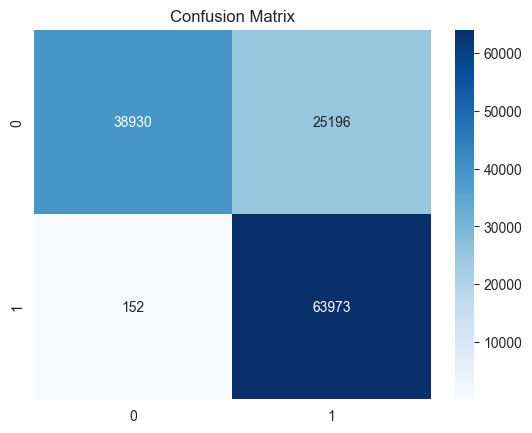

In [22]:
# Set the max_depth as an integer
best['max_depth'] = int(best['max_depth'])

# Train the model
xgb = XGBClassifier(**best,
                    n_estimators=100,
                    random_state = 2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Evaluate the model
print('Metrics : ')
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

Metrics : 
0.8023563169098097
0.8346445392513732


In [24]:
# y_test_2 = df_majoritie_excluded['order_ships'].to_numpy()
# X_test_2 = df_majoritie_excluded.drop(columns=['order_ships']).to_numpy()

# y_pred2 = xgb.predict(X_test_2)
# print(classification_report(y_test_2, y_pred2))
# sns.heatmap(confusion_matrix(y_test_2, y_pred2), annot=True, fmt='d', cmap='Blues')

### ROC Curve

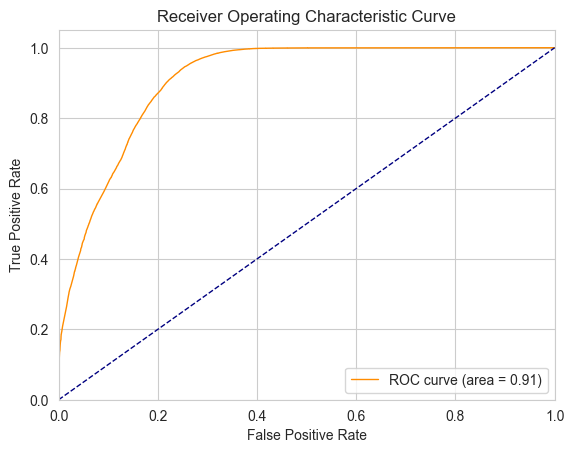

In [25]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

### Most Important Features

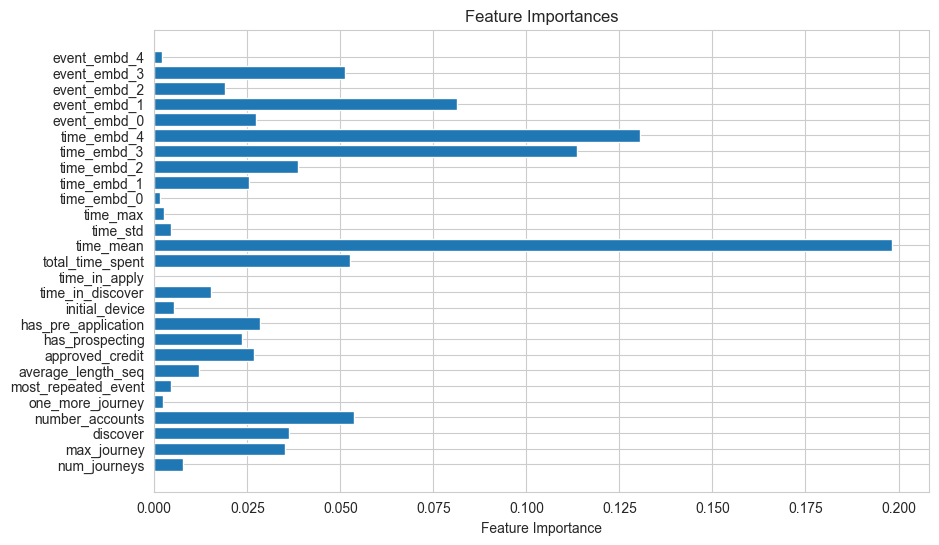

In [26]:
# Columns
x = list(new_dfx.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Cross Validation

For the original data set with the customers it takes approximately 12m 58s to run in my local machine.

In [32]:
# As we have that X is a numpy and not a dataframe we convert it to a dataframe
X = pd.DataFrame(X, columns=new_dfx.drop(columns=['order_ships']).columns)
y = pd.DataFrame(y, columns=['order_ships'])

#### XGBoost

In [33]:
# Model
xgb = XGBClassifier(**best, 
                    n_estimators=100,
                    random_state = 2024)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score mean:', np.mean(f1_scores))
print('F1 Score std:', np.std(f1_scores))
print('Accuracy mean:', np.mean(accuracy_scores))
print('Accuracy std:', np.std(accuracy_scores))

F1 Score: 0.8340921546652282
F1 Score: 0.0008856022174736244
Accuracy: 0.8015585145010554
Accuracy: 0.0013051272261842292


#### LogisticRegression

In [34]:
lr = LogisticRegression(max_iter=1000, random_state=2024)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

F1 Score: 0.7935319075244609
Accuracy: 0.7768888888888889


In [35]:
# Model
lr = LogisticRegression(max_iter=1000, random_state=2024)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

F1 Score: 0.7925478867921821
F1 Score: 0.0010096873143104039
Accuracy: 0.7754876387969906
Accuracy: 0.001351134547373215


#### GaussianNB

In [36]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

F1 Score: 0.2622430805631752
Accuracy: 0.5575126705653022


In [37]:
# Model
gnb = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

F1 Score: 0.26281233988778896
F1 Score: 0.002957105227733549
Accuracy: 0.5574968999310761
Accuracy: 0.000935571962854272


## Ensemble Model

* This took 9 mins without the SVC model

In [38]:
# create the individual models
clf1 = LogisticRegression(random_state=2024)
clf2 = RandomForestClassifier(random_state=2024)
clf3 = GaussianNB()
clf4 = XGBClassifier(**best, 
                     n_estimators=100,
                     random_state=2024)
clf5 = LGBMClassifier(random_state=2024)
clf6 = GradientBoostingClassifier(random_state=2024)
clf7 = AdaBoostClassifier(random_state=2024)
clf6 = DecisionTreeClassifier(random_state=2024)

# create the ensemble model
eclf = VotingClassifier(
    estimators=[('lr', clf1),
                ('rf', clf2),
                ('gnb', clf3),
                ('xgb', clf4),
                ('lgbm', clf5),
                ('gbc', clf6),
                ('abc', clf7),
                ('dtc', clf6),],
    voting='hard')

# fit the ensemble model
eclf = eclf.fit(X_train, y_train)

# make predictions
y_pred = eclf.predict(X_test)

# evaluate the ensemble model
print('Metrics : ')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 256501, number of negative: 256501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4380
[LightGBM] [Info] Number of data points in the train set: 513002, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Metrics : 
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     64125
         1.0       0.83      0.93      0.87     64125

    accuracy                           0.87    128250
   macro avg       0.87      0.87      0.87    128250
weighted avg       0.87      0.87      0.87    128250



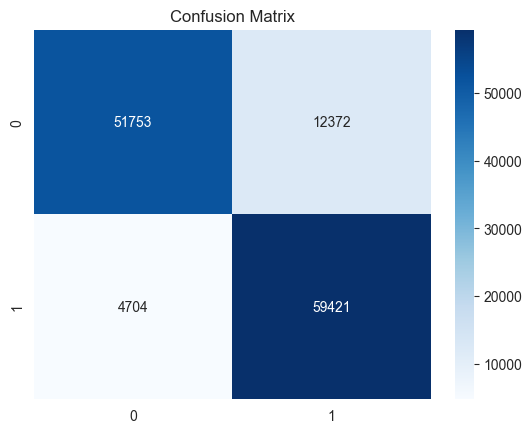

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [40]:
f1_score(y_test, y_pred)

0.8743654262128637

In [41]:
accuracy_score(y_test, y_pred)

0.8668538011695907